### Libaries and Modules Used:

In [288]:
import config
from bs4 import BeautifulSoup
import requests
import mysql.connector 
from mysql.connector import errorcode
import json
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
pd.set_option('display.max_columns', None)
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

## Webscraping Billboard 100 Website

In order to identify the sample for our analysis, we decided to scrape the Billboard100.com website (weekly 100 chart) for song name and artist names. We needed this data to ping the Spotfiy API for further information on the songs. The following code includes the functions needed to webscrape and upload the data into an AWS Database.

In [ ]:
def iterate_dates(start_y, start_m, start_d, end_y, end_m, end_d):
    """
    Function that takes in year, month, and day parameters
    for both start and end dates and outputs a list of Saturdays.
    Since the Billboard100 website's weekly charts are posted on
    Saturdays, this gives us the dates to scrape. 
    """
    start_date = datetime.date(start_y, start_m, start_d)
    end_date = datetime.date(end_y, end_m, end_d)
    saturdays = []
    while start_date < end_date:
        if start_date.weekday() != 5:
            start_date += datetime.timedelta(days=1)
        else: 
            saturdays.append(start_date.isoformat())
        start_date += datetime.timedelta(days=1)
    return saturdays

In [ ]:
# Collects missing dates. In case Billboard100 times out during webscraping
missing_dates = []

In [226]:
def get_data(date_):
    """
    Function that takes in a single date and goes to the billboard100
    weekly top 100 chart for that date. Gets the song name, artist,
    and rank information (current rank, peak rank, duration, etc.)
    for the song as of the input date.
    """
    url = "http://www.billboard.com/charts/hot-100/"+date_
    request = requests.get(url)
    if request.status_code != 200:
        return False
    soup = BeautifulSoup(request.content, 'html.parser')
    song_titles = clean(soup.find_all(class_ = 'chart-element__information__song text--truncate color--primary'))
    song_rankings = clean(soup.find_all(class_ = 'chart-element__rank__number'))
    song_artists = clean(soup.find_all(class_ = 'chart-element__information__artist text--truncate color--secondary'))
    peak_ranking = clean(soup.find_all(class_ = 'chart-element__meta text--center color--secondary text--peak'))
    weeks_top_100 = clean(soup.find_all(class_ = 'chart-element__meta text--center color--secondary text--week'))
    billboard_week = clean(soup.find_all(class_ = "date-selector__button button--link"))
    
    weekly_ranking = []
    for i in range(len(song_rankings)):
        song_list = [song_rankings[i], song_titles[i], song_artists[i], peak_ranking[i], weeks_top_100[i]]
        weekly_ranking.append(song_list)
    weekly_dict = {billboard_week[0]: weekly_ranking}
    return weekly_dict

In [3]:
def clean(lst):
    """
    Cleans the text obtained via webscrapping
    the Billboard 100 website
    """
    clean_lst = []
    for i in lst:
        j = i.text.strip()
        clean_lst.append(j)
    return clean_lst

In [12]:
def get_billboard_data(start_y, start_m, start_d, end_y, end_m, end_d):
    """
    Function that takes in dates and webscrapes the Billboard100
    website for song rank information between those dates.
    Returns a dictionary with a key representing the week
    and a value that is a list of 100 lists representing all song
    rank information.
    """
    import time
    saturdays = iterate_dates(start_y, start_m, start_d, end_y, end_m, end_d)
    billboard_dict = {}
    print(billboard_dict)
    for i in saturdays:
        print(i)
        rndm_sleep = np.random.random(size=1)*20
        time.sleep(rndm_sleep)
        temp = get_data(i)
        if temp == False:
            missing_dates.append(i)
            continue
        print(temp)
        billboard_dict.update(temp)
    return billboard_dict

In [45]:
def format_and_send_to_db_billboard(billboard_dict):
    """
    Function that formats into typles
    and uploads billboard100 rank data
    into an AWS RDB"""
    billboard_tuples_lst = format_billboard_dict(billboard_dict)
    print(billboard_tuples_lst[0])
    put_in_db_billboard(billboard_tuples_lst)

In [31]:
#One-time table creation to house Billboard100 data
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.passwd,
    database = config.database)
cursor = cnx.cursor()
cursor.execute("""CREATE TABLE billboard(
                  date TEXT,
                  rank INT,
                  song_name TEXT,
                  artist TEXT,
                  peak_rank INT,
                  duration_on_chart INT)""")
cnx.commit()
cursor.close()

In [19]:
def format_billboard_dict(billboard_dict):
    """ 
    Changes the dictionary (output from get_billboard_data)
    into a list of tuples 
    """
    billboard_tuples_lst = []
    for key, value in billboard_dict.items():
        for i in value:
            billboard_tuple = (key, i[0], i[1], i[2], i[3], i[4])
            billboard_tuples_lst.append(billboard_tuple)
    return billboard_tuples_lst

In [25]:
def put_in_db_billboard(billboard_tuples_lst):
    """
    Sends a list of tuples containing billboard100
    song rank information to the AWS DB
    """
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
    database = config.database)
    cursor = cnx.cursor()
    stmt = "INSERT INTO billboard (date, rank, song_name, artist, peak_rank, duration_on_chart) VALUES (%s, %s, %s, %s, %s, %s)"
    for i in billboard_tuples_lst:
        cursor.execute(stmt, i)
        cnx.commit()
    cursor.close()

# Spotify API
## Getting Track Information

To answer our questions about track attributes (duration, explicit or not, tempo, musicality) and Billboard100 ranking, needed to ping the Spotify API with the appropriate track id. 

First we used the Spotify search endpoint to get the initial track data - including Spotify track ID - and then did an additional call to the track musicality endpoint to obtain the musicality stats. Both track info and track musicality were uploaded to separate tables in the AWD Database.

In [ ]:
def get_token():
    response = requests.post(
        'https://accounts.spotify.com/api/token',
        params={'grant_type': 'client_credentials',
                'client_id': config.client_id, 'client_secret':config.client_secret},
        headers = { 'content-type': "application/x-www-form-urlencoded" })
    token = response.json()
    return token

In [ ]:
def list_from_billboard(year):
    """
    Selects distinct song artist pairs from billboard table from a specific year
    and places them all into a list
    """

    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
        database = 'music')
    cursor = cnx.cursor()
    q = """SELECT DISTINCT song_name, artist FROM billboard WHERE date LIKE '%"""+str(year)+"'"
    cursor.execute(q)
    artist_song_list = cursor.fetchall()
    return artist_song_list

In [ ]:
def make_track_info_list(artist_song_list):
    """
    iterates through each song/artist in artist_song_list and calls
    song ID, album, explicit, release date, popularity, and duration
    from spotify API. Places all this info into a list for each song 
    and returns a list of these lists.
    """
    token = get_token()
    track_info_list = []
    for i in artist_song_list:
        song_name = str(i[0])
        artist = str(i[1])
        song_list = []
        if '**' in song_name:
            song_name = song_name.replace("**","uc")
        if '(#' in song_name:
            song_name = song_name.replace('(#','')
        if ')' in song_name:
            song_name = song_name.replace(')','')
        if '%' in song_name:
            song_name = song_name.replace('%', 'percent')
  
        response = requests.get(f'https://api.spotify.com/v1/search?q={song_name}+{artist.split()[0]}&type=track',
             headers={'Authorization': 'Bearer '+token['access_token']})
        print(response.status_code)
        print(song_name,artist)
        track_info = response.json()
    

        if response.status_code == 400 or response.status_code ==501 or track_info['tracks']['items'] == []:
            failure_list.append([song_name, artist])
            #print(track_info['tracks']['items'])
            continue
        if response.status_code == 401:
            token = get_token()
            response = requests.get(f'https://api.spotify.com/v1/search?q={song_name}+{artist.split()[0]}&type=track',
             headers={'Authorization': 'Bearer '+token['access_token']})
            track_info = response.json()
        

           
        print(len(track_info['tracks']['items']))
        song_list.append(track_info['tracks']['items'][0]['id'])
        song_list.append(i[0])
        song_list.append(track_info['tracks']['items'][0]['duration_ms'])
        song_list.append(i[1])
        song_list.append(track_info['tracks']['items'][0]['album']['id'])
        song_list.append(track_info['tracks']['items'][0]['album']['name'])
        song_list.append(track_info['tracks']['items'][0]['explicit'])
        song_list.append(track_info['tracks']['items'][0]['album']['release_date'])
        song_list.append(track_info['tracks']['items'][0]['popularity'])
        track_info_list.append(song_list)
   
    return track_info_list

In [ ]:
def format_track_list(track_info_list):
    """
    Iterates through each list in track_info_list and converts it into a tuple.
    Returns a list of all of these tuples.
    """
    song_tuples_list = []
    for i in track_info_list:
        song_tuple = (i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8])
        song_tuples_list.append(song_tuple)
        
    return song_tuples_list

In [ ]:
def put_in_db_songs(song_tuples_list):
    """
    Inserts each tuple in song_tuples_list into SQL database
    """
    cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.passwd,
    database = 'music')
    cursor = cnx.cursor()
    stmt = "INSERT INTO song_info (song_id, song_name, length, artist, album_id, album, explicit, release_date, popularity) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
    for i in song_tuples_list:
        cursor.execute(stmt, i)
        cnx.commit()

In [ ]:
def all_at_once(year):
    """
    takes songs from year from billboard table, uses those songs to call
    API, formats API info into tuples, puts it into song_info table all at once.
    """
    artist_song_list = list_from_billboard(year)
    #print(artist_song_list)
    track_info_list = make_track_info_list(artist_song_list)
    #print(track_info_list)
    song_tuples_list = format_track_list(track_info_list)
    #print(song_tuples_list)
    put_in_db_songs(song_tuples_list)

## Set up Song Info table

In [ ]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.passwd,
    database = 'music')
cursor = cnx.cursor()
cursor.execute("""CREATE TABLE song_info (
                    song_id VARCHAR(55),
                    song_name TEXT,
                    length INT,
                    artist TEXT,
                    album_id TEXT,
                    album TEXT,
                    explicit BOOL,
                    release_date DATETIME,
                    popularity INT)""")
cnx.commit()

## Getting Musicality from Spotify

In [192]:
def get_track_ids():
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
        database = 'music')
    cursor = cnx.cursor()
    stmt = "SELECT DISTINCT i.song_id FROM song_info i LEFT JOIN (SELECT DISTINCT song_id from musicality) s ON s.song_id = i.song_id WHERE s.song_id is NULL"
    cursor.execute(stmt)
    track_id_list = cursor.fetchall()
    return track_id_list

In [220]:
# Failure list to capture any song ids for which musicality did not exist
failure_list = []

In [218]:
def get_musicality(track_id_list):
    """
    Function that takes in a list of Spotify track IDs
    and pings the Spotify track muscality endpoint to 
    obtain musicality stats for each track.
    Returns a list of lists including the unique
    song ID and all musicality stats
    """
    track_musicality_list = []
    token = get_token()
    for count, track in enumerate(track_id_list):
        track_musicality = []
        print(count)
        response = requests.get(f'https://api.spotify.com/v1/audio-features/{track[0]}',
                 headers={'Authorization': 'Bearer '+token['access_token']})
        track_info = response.json()
        print(response.status_code)
        if response.status_code == 400 or response.status_code ==501:
            failure_list.append(track)
            continue
        
        if response.status_code == 401:
            token = get_token()
            response = requests.get(f'https://api.spotify.com/v1/audio-features/{track[0]}',
                 headers={'Authorization': 'Bearer '+token['access_token']})
        print(response.json())
        track_info = response.json()
        track_musicality.append(track[0])
        track_musicality.append(track_info['danceability'])
        track_musicality.append(track_info['energy'])
        track_musicality.append(track_info['key'])
        track_musicality.append(track_info['loudness'])
        track_musicality.append(track_info['mode'])
        track_musicality.append(track_info['speechiness'])
        track_musicality.append(track_info['acousticness'])
        track_musicality.append(track_info['instrumentalness'])
        track_musicality.append(track_info['liveness'])
        track_musicality.append(track_info['valence'])
        track_musicality.append(track_info['tempo'])
        track_musicality_list.append(track_musicality)
    return track_musicality_list


In [ ]:
def get_musicality():
    """
    Aggregate function that gets the track ids
    from the AWS database, pings the Spotify API
    to obtain the musicality, formats the data
    and puts it into the AWS database
    """
    track_id_list = get_track_ids()
    musicality_list = get_musicality(track_id_list)
    musicality_tuples_list = format_track_musicality(musicality_list)
    put_in_db_track_musicality(musicality_tuples_list)

In [236]:
# One-time table creation to house musicality stats by track
cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
        database = 'music')
cursor = cnx.cursor()
cursor.execute("""CREATE TABLE musicality (
                    song_id VARCHAR(55),
                    danceability REAL,
                    energy REAL,
                    key REAL,
                    loudness REAL,
                    mode REAL,
                    speechiness REAL,
                    acousticness REAL,
                    instrumentalness REAL,
                    liveness REAL,
                    valence REAL,
                    tempo REAL)""")
cnx.commit()
cursor.close()

In [235]:
def format_track_musicality(musicality_list):
    """
    Formats the track musicality list 
    into a tuple for upload to the AWD Database
    """
    musicality_tuples_list = []
    for i in musicality_list:
        musicality_tuple = (i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9], i[10], i[11])
        musicality_tuples_list.append(musicality_tuple)
    return musicality_tuples_list

In [165]:
def put_in_db_track_musicality(musicality_tuples_list):
    """
    Uploads list of musicality tuples
    into the AWS database
    """
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
        database = 'music')
    cursor = cnx.cursor()
    stmt = """INSERT INTO musicality (song_id, danceability, energy, key_, loudness, mode, speechiness, 
                                        acousticness, instrumentalness, liveness, valence, tempo) 
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    for i in musicality_tuples_list:
        cursor.execute(stmt, i)
        cnx.commit()

# Statistical Analysis

## Add a column 'recent' and put into pandas dataframe

In [293]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.passwd,
    database = 'music')
cursor = cnx.cursor()
cursor.execute("""SELECT DISTINCT *
FROM song_info """)

df_song_info = pd.DataFrame(cursor.fetchall())
df_song_info.columns = [x[0] for x in cursor.description]

df_song_info['recent'] = df_song_info['release_date'].map(lambda x: True if x.year >= 2010 else False)
df_song_info['recent']
df_song_info

,song_id,song_name,length,artist,album_id,album,explicit,release_date,popularity,recent
0,0tgVpDi06FyKpA1z0VMD4v,Perfect,263400,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,÷ (Deluxe),0,2017-03-03,87,True
1,1rfofaqEpACxVEHIZBJe6W,Havana,217306,Camila Cabello Featuring Young Thug,2vD3zSQr8hNlg0obNel4TE,Camila,0,2018-01-12,85,True
2,7MXVkk9YMctZqd1Srtv4MB,Starboy,230453,The Weeknd Featuring Daft Punk,2ODvWsOgouMbaA5xf0RkJe,Starboy,1,2016-11-25,82,True
3,6fujklziTHa8uoM5OQSfIo,Black Beatles,291893,Rae Sremmurd Featuring Gucci Mane,5v6iBhIlflzR9rEd1LAMbd,SremmLife 2 (Deluxe),1,2016-08-12,76,True
4,7BKLCZ1jbUBVqRi2FVlTVw,Closer,244960,The Chainsmokers Featuring Halsey,0rSLgV8p5FzfnqlEk4GzxE,Closer,0,2016-07-29,85,True
5,6b8Be6ljOzmkOmFslEb23P,24K Magic,225983,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,24K Magic,0,2016-11-17,78,True
6,1lItf5ZXJc1by9SbPeljFd,Juju On That Beat (TZ Anthem),144244,Zay Hilfigerrr & Zayion McCall,5sQTfUX9uSwfCtPiYGO20V,Juju On That Beat (TZ Anthem),0,2016-09-30,64,True
7,1pKeFVVUOPjFsOABub0OaV,Side To Side,226160,Ariana Grande Featuring Nicki Minaj,3OZgEywV4krCZ814pTJWr7,Dangerous Woman,1,2016-05-20,81,True
8,0lYBSQXN6rCTvUZvg9S0lU,Let Me Love You,205946,DJ Snake Featuring Justin Bieber,02sEJTj1sye1JaqxqpcSCp,Encore,0,2016-08-05,81,True
9,1nueTG77MzNkJTKQ0ZdGzT,Don't Wanna Know,214265,Maroon 5 Featuring Kendrick Lamar,3ThQ5dvf9wlqB0C7evh5nH,Red Pill Blues (Deluxe),0,2018-06-15,69,True


## Chi Squared Test
Does song length differ between recent songs and past songs?

### Hypotheses:
- **Null:**  No difference in length between recent and older songs
- **Alternative:** A difference exists in length between old and recent songs

- **Independent Variable:** Whether song is recent (2010’s) or old (2000’s)
- **Dependent Variable:** Length of song in milliseconds

In [294]:
# test if there is a difference in song length between recent and past songs using Chi squared test
df2 = df_song_info[['length','recent']]
df2
df2['length'] = pd.cut(x=df2.length, bins=[0, 60000, 90000, 120000, 150000, 180000, 210000, 240000, 270000, 300000, 330000, 360000, 390000, 420000])
df2

length_table = pd.crosstab(df2['length'], df2['recent'])
length_table
chi2, p, dof, expected = stats.chi2_contingency(length_table)
print(chi2, p, dof, expected)


/Users/kathringo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


130.42224665883268 5.077651909169691e-22 12 [[8.65661412e-01 1.13433859e+00]
 [1.73132282e+00 2.26867718e+00]
 [8.65661412e+00 1.13433859e+01]
 [3.72234407e+01 4.87765593e+01]
 [1.48460932e+02 1.94539068e+02]
 [6.15485264e+02 8.06514736e+02]
 [8.59168951e+02 1.12583105e+03]
 [4.99919465e+02 6.55080535e+02]
 [2.19445168e+02 2.87554832e+02]
 [8.57004798e+01 1.12299520e+02]
 [3.24623029e+01 4.25376971e+01]
 [1.29849212e+01 1.70150788e+01]
 [3.89547635e+00 5.10452365e+00]]


In [295]:
# remove extreme outliers from sample
df_song_info[df_song_info['length']>600000]
df_song_info = df_song_info.set_index("song_name")
df_song_info = df_song_info.drop("Not A Bad Thing", axis=0)
df_song_info = df_song_info.drop("Trapped In The Closet", axis=0)

Text(0, 0.5, 'milliseconds')

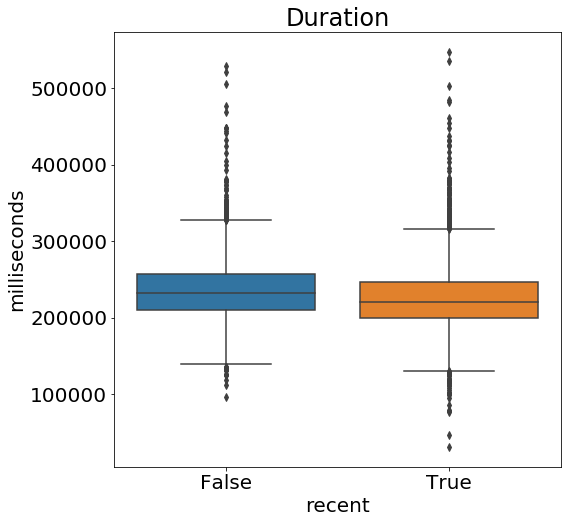

In [616]:
import matplotlib.pyplot as plt
df2 = df_song_info[['length','recent']]
df2
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
sns.boxplot(x = 'recent', y='length',  data=df2, ax=ax)
plt.title('Duration')
plt.rcParams.update({'font.size': 20})
plt.ylabel('milliseconds')

### Results:
**Test statistic** = 130
**P-value** = 5.0e-22
**Reject null hypothesis** and conclude that there is a difference in length between recent and older songs

## Two sample t-test
Is there a difference in popularity between clean and explicit songs?

### Hypotheses:
- **Null:** No difference in popularity between clean and explicit songs
- **Alternative:** A difference exists in popularity between clean and explicit songs

- **Independent Variable:** Whether song is explicit or clean
- **Dependent Variable:** Spotify popularity of song

In [489]:
#difference in popularity between explicit and clean using two sample t test
df_song_info
df_expl = df_song_info[df_song_info['explicit'] == 1]
df_clean = df_song_info[df_song_info['explicit'] == 0]
df_expl = df_expl['popularity']
df_expl
df_clean = df_clean['popularity']
t, p = ttest_ind(df_expl, df_clean, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

# Explicit songs are more popular on average than clean songs; could be because current songs are more popular and explicit

ttest_ind:            t = 12.5453  p = 2.50156e-35


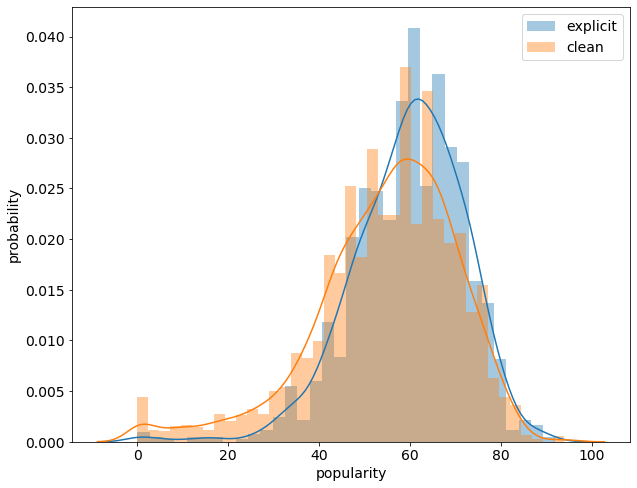

In [610]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
sns.distplot(df_song_info[df_song_info['explicit']==True].popularity, ax=ax1, norm_hist=True, label='explicit')
sns.distplot(df_song_info[df_song_info['explicit']==False].popularity, ax=ax1, norm_hist=True, label = 'clean')
plt.ylabel('probability')
plt.legend()
plt.rcParams.update({'font.size': 20})

## Results:
**Test statistic**  = 12.5
**P-value** = 2.5e-35
**Reject null hypothesis** and conclude that a difference exists in popularity between clean and explicit songs

In [4]:
# Links the billboard100, musicality
cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd,
        database = 'music')
cursor = cnx.cursor()

q = """SELECT DISTINCT b.song_name, 
				b.artist, 
                min(peak_rank), 
                max(duration_on_chart), 
                s.song_id, 
                length, 
                album_id, 
                album, 
                explicit, 
                release_date, 
                popularity,
                danceability,
                energy,
                key_,
                loudness,
                mode,
                speechiness,
                acousticness,
                liveness,
                valence,
                tempo
FROM music.billboard b 
JOIN (
		SELECT DISTINCT song_id, 
						song_name, 
                        length, 
                        artist, 
                        album_id, 
                        album, 
                        explicit, 
                        release_date, 
                        popularity 
		FROM music.song_info
		) s 
ON s.song_name = b.song_name AND s.artist = b.artist 
JOIN (
		SELECT DISTINCT *
		FROM music.musicality
		) m
ON m.song_id = s.song_id
GROUP BY song_name, artist;"""

cursor.execute(q)
df = pd.DataFrame(cursor.fetchall())
df.columns = [x[0] for x in cursor.description]

In [11]:
# Create a new categorical variable using release_date to identify the season in which a song was released
df['release_season'] = df['release_date'].map(lambda x: 'Summer' if x.month in [6,7,8] else ('Fall' if x.month in [9, 10, 11] else ('Spring' if x.month in [3, 4, 5] else ('Winter' if x.month in [12, 1, 2] else 'Unknown'))))

In [18]:
formula = """peak_rank ~ length + explicit + 
            popularity + danceability + energy + key_ + loudness + 
            mode + speechiness + acousticness + liveness + valence + tempo"""

In [20]:
# updates column names
column_names = list(df.columns)
column_names[2] = 'peak_rank'
column_names[3] = 'max_duration_on_chart'
df.columns = column_names

## ANOVA Testing
We want to test if there is a relationship between the musicality of a song and its peak rank on the Billboard100 chart.
### Hypotheses:
- **Null:** There is no relationship between the “musicality” of a song and how high it charts
- **Alternative:** There exists a relationship between the musicality of a song and how high it charts

### Dependent and Independent Variables
- **Dependent Variable**: Peak rank (From 1 to 100)
- **Independent Variables**: Musicality (mostly continuous except for Mode which is either Major or Minor. See additional descriptions of musicality on the Spotify website: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)
    - Danceability
    - Energy
    - Key
    - Loudness
    - Mode
    - Speechiness
    - Acousticness
    - Liveness
    - Valence 


In [239]:
# Specifying the dependent and independent variables, and the relationship
formula = """peak_rank ~ danceability + energy + key_ + loudness + 
            mode + speechiness + acousticness + liveness + valence"""

In [240]:
# Conducting the ANOVA test
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
danceability,3.201172e+04,1.0,36.033482,2.059522e-09
energy,2.336013e+04,1.0,26.294958,3.027646e-07
key_,1.347310e+03,1.0,1.516578,2.181891e-01
loudness,5.124551e+03,1.0,5.768369,1.634908e-02
mode,5.123854e+02,1.0,0.576758,4.476172e-01
speechiness,6.074760e+02,1.0,0.683796,4.083175e-01
acousticness,2.570464e+04,1.0,28.934022,7.788098e-08
liveness,1.785701e+01,1.0,0.020100,8.872619e-01
valence,9.366742e+03,1.0,10.543524,1.172727e-03
Residual,5.047822e+06,5682.0,NaN,NaN


In [242]:
# Renaming columns for readability
for column in table.columns:
    table[column] = table[column].map(lambda x: round(x, 3))
new_column_names = ['Sum of Squares', 'dof', 'F-Test Statistic', 'p-value']
table.columns = new_column_names
table

,Sum of Squares,dof,F-Test Statistic,p-value
danceability,32011.721,1.0,36.033,0.000
energy,23360.131,1.0,26.295,0.000
key_,1347.310,1.0,1.517,0.218
loudness,5124.551,1.0,5.768,0.016
mode,512.385,1.0,0.577,0.448
speechiness,607.476,1.0,0.684,0.408
acousticness,25704.644,1.0,28.934,0.000
liveness,17.857,1.0,0.020,0.887
valence,9366.742,1.0,10.544,0.001
Residual,5047821.815,5682.0,NaN,NaN


In [243]:
# Obtain R-squared value
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              peak_rank   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     14.81
Date:                Fri, 04 Oct 2019   Prob (F-statistic):           5.01e-24
Time:                        11:35:34   Log-Likelihood:                -27394.
No. Observations:                5692   AIC:                         5.481e+04
Df Residuals:                    5682   BIC:                         5.487e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       43.5773      4.452      9.789      0.000      34.850      52.304
danceability   -18.7087      3.117     -6.003      0.000     -24.819     -12.599
energy          20.2354      3.946      5.128      0.000      12.499      27.971
key_            -0.1366      0.111     -1.231      0.218      -0.354       0.081
loudness        -0.5807      0.242     -2.402      0.016      -1.055      -0.107
mode             0.6599      0.869      0.759      0.448      -1.044       2.363
speechiness      3.3133      4.007      0.827      0.408      -4.542      11.168
acousticness    12.2514      2.278      5.379      0.000       7.786      16.716
liveness         0.3980      2.807      0.142      0.887      -5.106       5.902
valence         -7.0500      2.171     -3.247      0.001     -11.306      -2.794
==============================================================================
Omnibus:                     4695.609   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.193
Skew:                           0.057   Prob(JB):                     4.94e-75
Kurtosis:                       1.804   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Visualizations (Scatterplots) of some more significant musicality features and Peak Chart Rank

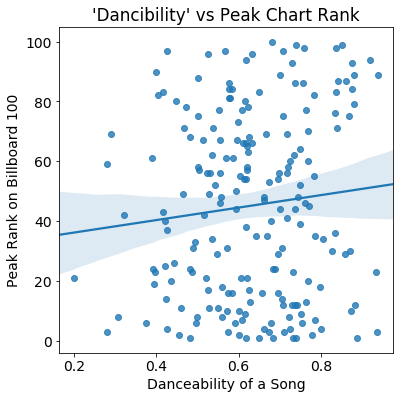

In [251]:
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})
ax1 = fig.add_subplot(111)

plt.title("'Dancibility' vs Peak Chart Rank")

sns.regplot(x = 'danceability', y = 'peak_rank', data = df.sample(200), fit_reg=True)
plt.xlabel('Danceability of a Song')
plt.ylabel('Peak Rank on Billboard 100')
# plt.legend()
plt.show()

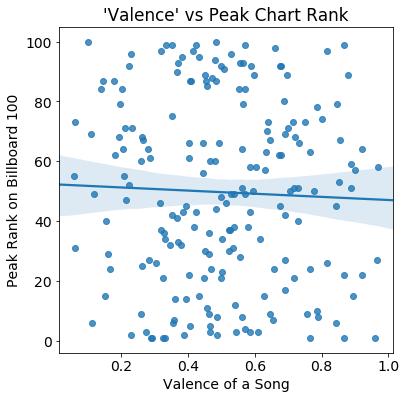

In [250]:
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})
ax1 = fig.add_subplot(111)

plt.title("'Valence' vs Peak Chart Rank")

sns.regplot(x = 'valence', y = 'peak_rank', data = df.sample(200), fit_reg=True)
plt.xlabel('Valence of a Song')
plt.ylabel('Peak Rank on Billboard 100')
# plt.legend()
plt.show()

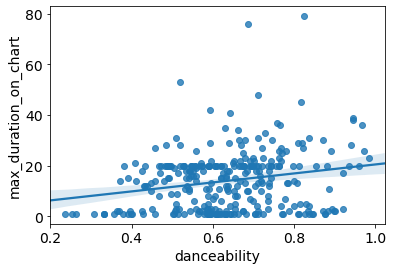

In [249]:
sns.regplot(x = 'danceability', y = 'max_duration_on_chart', data = df.sample(300), fit_reg=True);

In [253]:
# Viewing correlation between musicality features
df.corr()

,peak_rank,max_duration_on_chart,length,explicit,popularity,danceability,energy,key_,loudness,mode,speechiness,acousticness,liveness,valence,tempo,num_one_song,release_year
peak_rank,1.000000,-0.740581,-0.063236,-0.001184,-0.375019,-0.123457,0.010095,-0.016265,-0.014988,0.025792,-0.014769,0.065272,0.014174,-0.067348,0.024938,-0.294243,0.102545
max_duration_on_chart,-0.740581,1.000000,0.041232,-0.026191,0.432759,0.116680,0.038756,-0.002364,0.068306,0.003041,-0.030537,-0.093870,-0.052636,0.092485,-0.027514,0.315003,-0.114153
length,-0.063236,0.041232,1.000000,0.107362,0.000879,-0.100829,-0.069891,-0.013885,-0.075407,-0.039338,0.066723,0.023556,0.013054,-0.179783,-0.022771,0.032314,-0.151400
explicit,-0.001184,-0.026191,0.107362,1.000000,0.140278,0.308327,-0.062932,0.010844,-0.046996,-0.143857,0.498615,-0.083249,0.075668,-0.064437,-0.012606,0.010161,0.149737
popularity,-0.375019,0.432759,0.000879,0.140278,1.000000,0.105343,0.032982,-0.001407,0.105029,-0.062597,0.032593,-0.052667,-0.023087,0.003009,0.001392,0.184039,0.163722
danceability,-0.123457,0.116680,-0.100829,0.308327,0.105343,1.000000,0.015845,-0.012593,0.017942,-0.115396,0.216465,-0.161459,-0.067361,0.382125,-0.195924,0.095242,0.048212
energy,0.010095,0.038756,-0.069891,-0.062932,0.032982,0.015845,1.000000,0.021404,0.729770,-0.037573,0.016775,-0.576088,0.162278,0.427020,0.130327,-0.015529,-0.126160
key_,-0.016265,-0.002364,-0.013885,0.010844,-0.001407,-0.012593,0.021404,1.000000,0.013403,-0.127598,0.019505,-0.010059,0.006770,0.020792,-0.018094,-0.005736,-0.000366
loudness,-0.014988,0.068306,-0.075407,-0.046996,0.105029,0.017942,0.729770,0.013403,1.000000,-0.030321,-0.048569,-0.427903,0.093940,0.287120,0.080875,0.001100,-0.066229
mode,0.025792,0.003041,-0.039338,-0.143857,-0.062597,-0.115396,-0.037573,-0.127598,-0.030321,1.000000,-0.142196,0.054562,-0.013152,-0.053835,0.035717,-0.027396,-0.043432


### ANOVA Test Conclusion:
While we rejected the null hypothesis that there is no relationship between the “musicality” of a track and how high it reaches on the charts, the size of the effect (adjusted R-squared) appears to be too small to take advantage of. Only 2 % of the peak chart rank can be explained by the “musicality” of a song.

## 2-Sample T-Test

- **Dependent Variable:** Peak rank on the Billboard100 chart
    - **Note:** Peak rank does not appear to be normally distributed
- **Independent Variables:** Tempo (continuous variable that was changed to categorical)

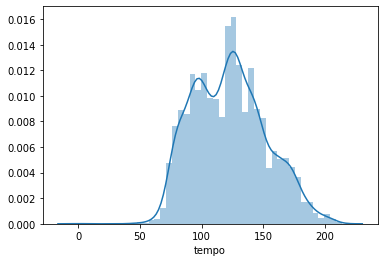

In [256]:
sns.distplot(df.tempo)

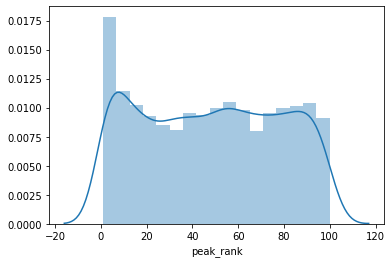

In [257]:
sns.distplot(df.peak_rank)

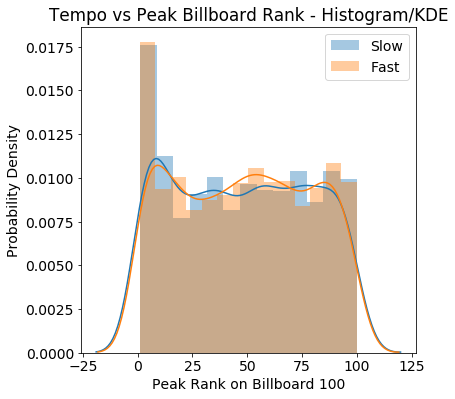

In [265]:
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})
ax1 = fig.add_subplot(111)

plt.title("Tempo vs Peak Billboard Rank - Histogram/KDE")

sns.distplot(df[df['tempo'] < 120].peak_rank, ax=ax1, norm_hist=True, label='Slow')
sns.distplot(df[df['tempo'] > 120].peak_rank, ax=ax1, norm_hist=True, label='Fast')

plt.xlabel('Peak Rank on Billboard 100')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


No handles with labels found to put in legend.


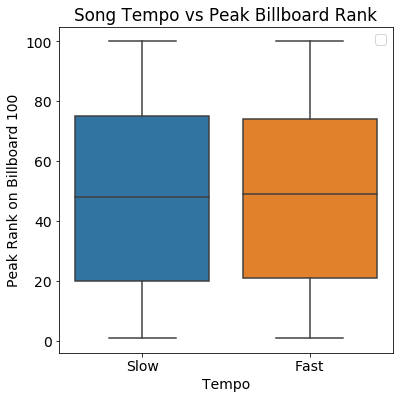

In [264]:
df['tempo_cat'] = df.tempo.map(lambda x: 'Fast' if x > 120 else 'Slow')

fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})
ax1 = fig.add_subplot(111)

plt.title("Song Tempo vs Peak Billboard Rank")

sns.boxplot(x='tempo_cat', y='peak_rank', data=df)
plt.xlabel('Tempo')
plt.ylabel('Peak Rank on Billboard 100')
plt.legend()
plt.show()

In [268]:
def get_sample(data, n):
    sample_lst = []
    while len(sample_lst) != n:
        x = np.random.choice(data)
        sample_lst.append(x)
    return sample_lst

In [270]:
slow_tempo_df = df[df['tempo'] < 120]
fast_tempo_df = df[df['tempo'] > 120]

In [284]:
slow_sampling_means = get_sample(slow_tempo_df.peak_rank, 100)
fast_sampling_means = get_sample(fast_tempo_df.peak_rank, 100)

In [287]:
# 2-Sample T-Test
stats.ttest_ind(slow_sampling_means, fast_sampling_means)

Ttest_indResult(statistic=-0.09278478904215676, pvalue=0.9261683494286597)

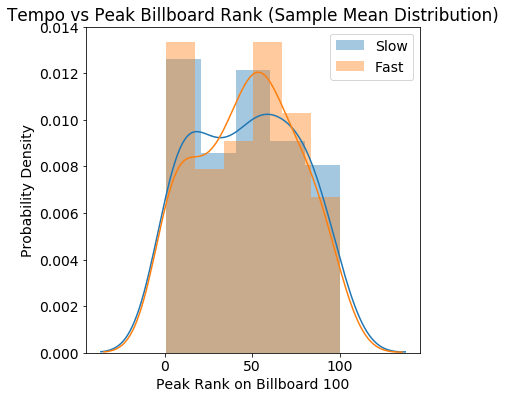

In [286]:
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})
ax1 = fig.add_subplot(111)

plt.title("Tempo vs Peak Billboard Rank (Sample Mean Distribution)")

sns.distplot(slow_sampling_means, ax=ax1, norm_hist=True, label='Slow')
sns.distplot(fast_sampling_means, ax=ax1, norm_hist=True, label='Fast')

plt.xlabel('Peak Rank on Billboard 100')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

### 2-Sample T-Test Test Conclusion:
The p-value is so high (> alpha level of 5%), so we reject the null hypothesis that there is a difference between how high on the charts fast songs vs slow songs reach.